# Proyecto Final - Predictor de estrés 
Elaborado por:

*Jonathan Javier Robayo Bossio T00062005* 

*Michael Andres Casadiegos Berrio T00061889*

*Carlos D Echeverri M  T00043616*

In [2]:
import pandas as pd 

### Importando Librerias necesarias 

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore') #Configuración para ignorar todas las advertencias que se emiten durante la ejecución del código
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)
sns.set_theme('notebook')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jhon78\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lectura de los datos

In [4]:
human_stress=pd.read_csv('Stress/Stress.csv')

In [5]:
human_stress.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087


In [6]:
human_stress.info() # información de la columnas de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


#### Selección de columna 'Subreddit'
Se selecciona esta columna para llevarse a cabo un analisis de la situación o caracteristicas de las que padesen las personas: **ptsd**: 'trastorno de estrés postraumático', **relationships**: 'relaciones', **anxiety**: 'ansiedad', **domesticviolence**: 'violencia domestica', **assistance**: 'asistencia', **survivorsofabuse**: 'supervivientes de abusos', **homeless**: 'persona sin hogar', **almosthomeless**: 'persona casi sin hogar', **stress**: 'estrés', **food_pantry**  

In [7]:
human_stress['subreddit'].value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

### Procesamiento de los datos para la creación de un dataframe

In [8]:
human_stress['len']=[len(text) for text in human_stress['text']]

In [9]:
human_stress['label_in_value']=human_stress['label'].map({0:'No Stress',1:"Stress"})

procesamiento de la fecha de los post

In [10]:
human_stress['date']=[ datetime.fromtimestamp(value) for value in human_stress['social_timestamp']]

In [11]:
human_stress['day']=[value for value in human_stress['date'].dt.day]

In [12]:
human_stress['month']=[value for value in human_stress['date'].dt.month]

In [13]:
human_stress['year']=[value for value in human_stress['date'].dt.year]

In [14]:
human_stress['hour']=[value for value in human_stress['date'].dt.hour]

In [15]:
human_stress['second']=[value for value in human_stress['date'].dt.second]

In [16]:
human_stress['day_name']=[value for value in human_stress['date'].dt.day_name()]

In [17]:
human_stress['day_of_week']=[value for value in human_stress['date'].dt.day_of_week]

In [18]:
human_stress.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,len,label_in_value,date,day,month,year,hour,second,day_name,day_of_week
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,571,Stress,2018-03-21 01:39:13,21,3,2018,1,13,Wednesday,2
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,588,No Stress,2018-05-22 12:23:37,22,5,2018,12,37,Tuesday,1
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,847,Stress,2018-09-02 19:46:45,2,9,2018,19,45,Sunday,6
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,1277,Stress,2018-01-20 01:25:55,20,1,2018,1,55,Saturday,5
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,533,Stress,2018-10-17 15:43:25,17,10,2018,15,25,Wednesday,2
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027,539,Stress,2018-01-29 20:00:27,29,1,2018,20,27,Monday,0
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409,588,No Stress,2017-12-09 16:20:09,9,12,2017,16,9,Saturday,5
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174,548,Stress,2017-01-04 21:09:34,4,1,2017,21,34,Wednesday,2
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984,436,Stress,2018-01-01 16:59:44,1,1,2018,16,44,Monday,0
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087,375,Stress,2017-03-25 02:48:07,25,3,2017,2,7,Saturday,5


### Se procede a eliminar algunas columnas que causan una fuga de información 

In [19]:
remove_cols=['post_id','sentence_range','confidence','social_timestamp','date']
human_stress.drop(remove_cols,axis=1,inplace=True)

In [20]:
human_stress.groupby('subreddit')['len'].describe().sort_values('count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ptsd,584.0,435.296233,157.677362,6.0,330.00,417.5,524.25,1271.0
relationships,552.0,463.898551,167.292838,142.0,354.00,428.0,539.00,1277.0
anxiety,503.0,447.763419,168.015419,6.0,338.00,418.0,532.50,1358.0
domesticviolence,316.0,436.512658,165.901395,6.0,335.00,406.5,512.25,1308.0
assistance,289.0,429.705882,143.763236,32.0,339.00,417.0,503.00,915.0
survivorsofabuse,245.0,473.485714,194.551557,88.0,348.00,437.0,559.00,1606.0
homeless,168.0,449.851190,177.114248,155.0,342.75,425.5,525.25,1281.0
almosthomeless,80.0,447.412500,208.517777,116.0,329.50,417.5,519.00,1639.0
stress,64.0,505.593750,203.001816,172.0,361.50,492.5,601.25,1354.0


## Visualización de datos

## Apenas hay diferencias entre la distribución en estrés y sin estrés

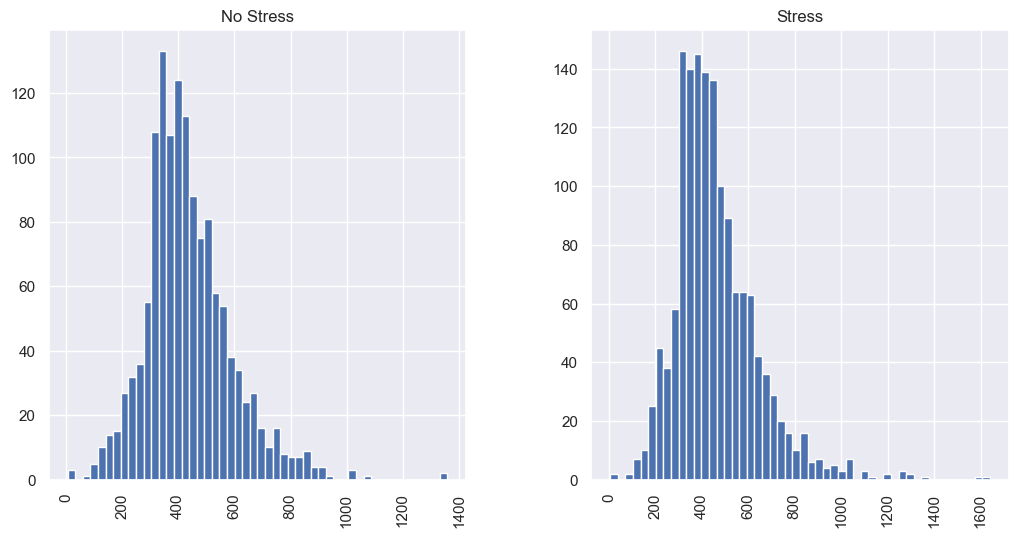

In [21]:
human_stress.hist(column='len',by='label_in_value',bins=50)
plt.show()

#### Viernes y martes para la longitud del texto son altos, lo cual los textos largos pueden indicar síntoma de estrés. 

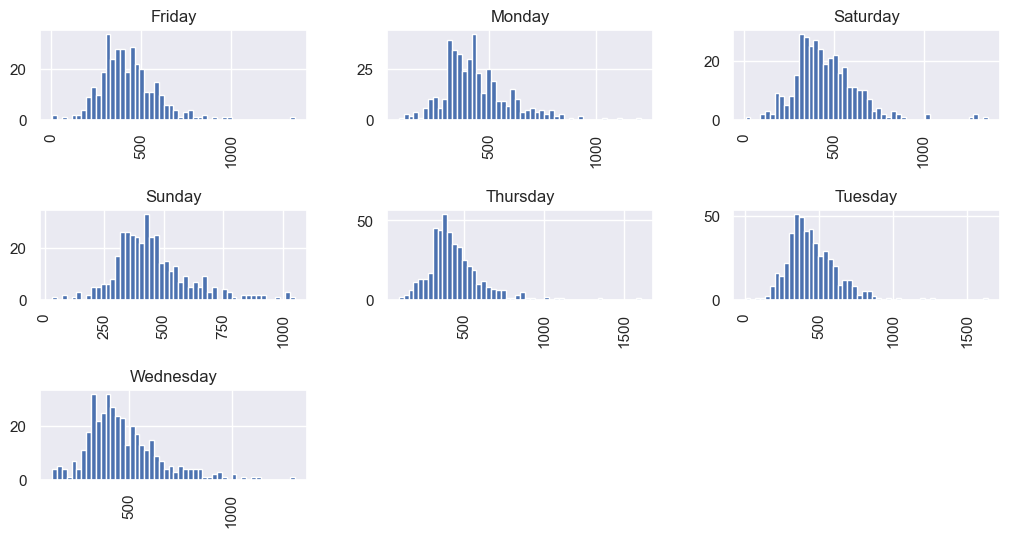

In [22]:
fig, ax = plt.subplots()
human_stress.hist(column='len',by='day_name',bins=50,ax=ax)
plt.subplots_adjust(hspace=1)
plt.show()

### La longitud de la cadena de texto del 2017 al 2018 se ve un claro aumento, por ende se puede interpretar como un aumento de estrés

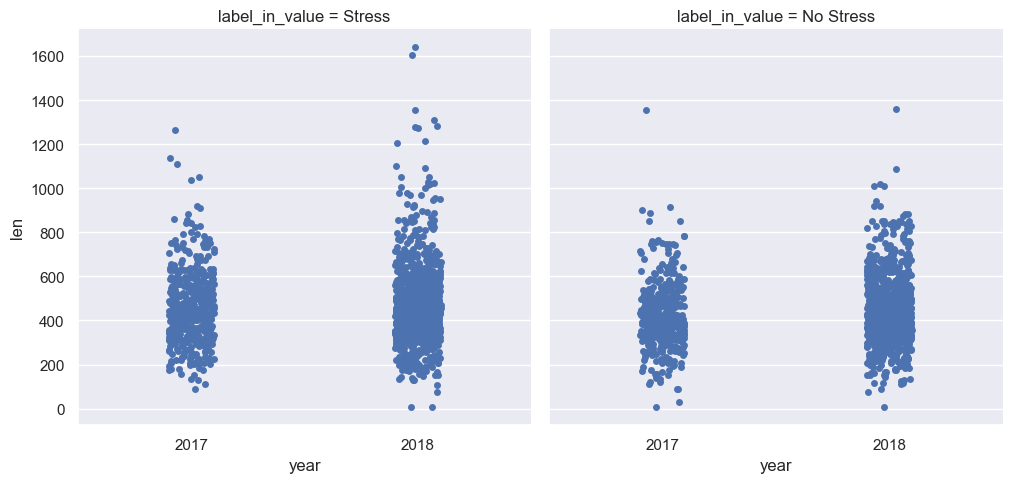

In [23]:
sns.catplot(data=human_stress,x='year',y='len',col='label_in_value',sharex=False,col_wrap=3)
plt.show()

## Los principales casos están en 
### 1. trastorno de estrés postraumático
### 2. superviviente de abusos
### 3. Violencia doméstica
### 4. Ansiedad
### 5. Sin techo

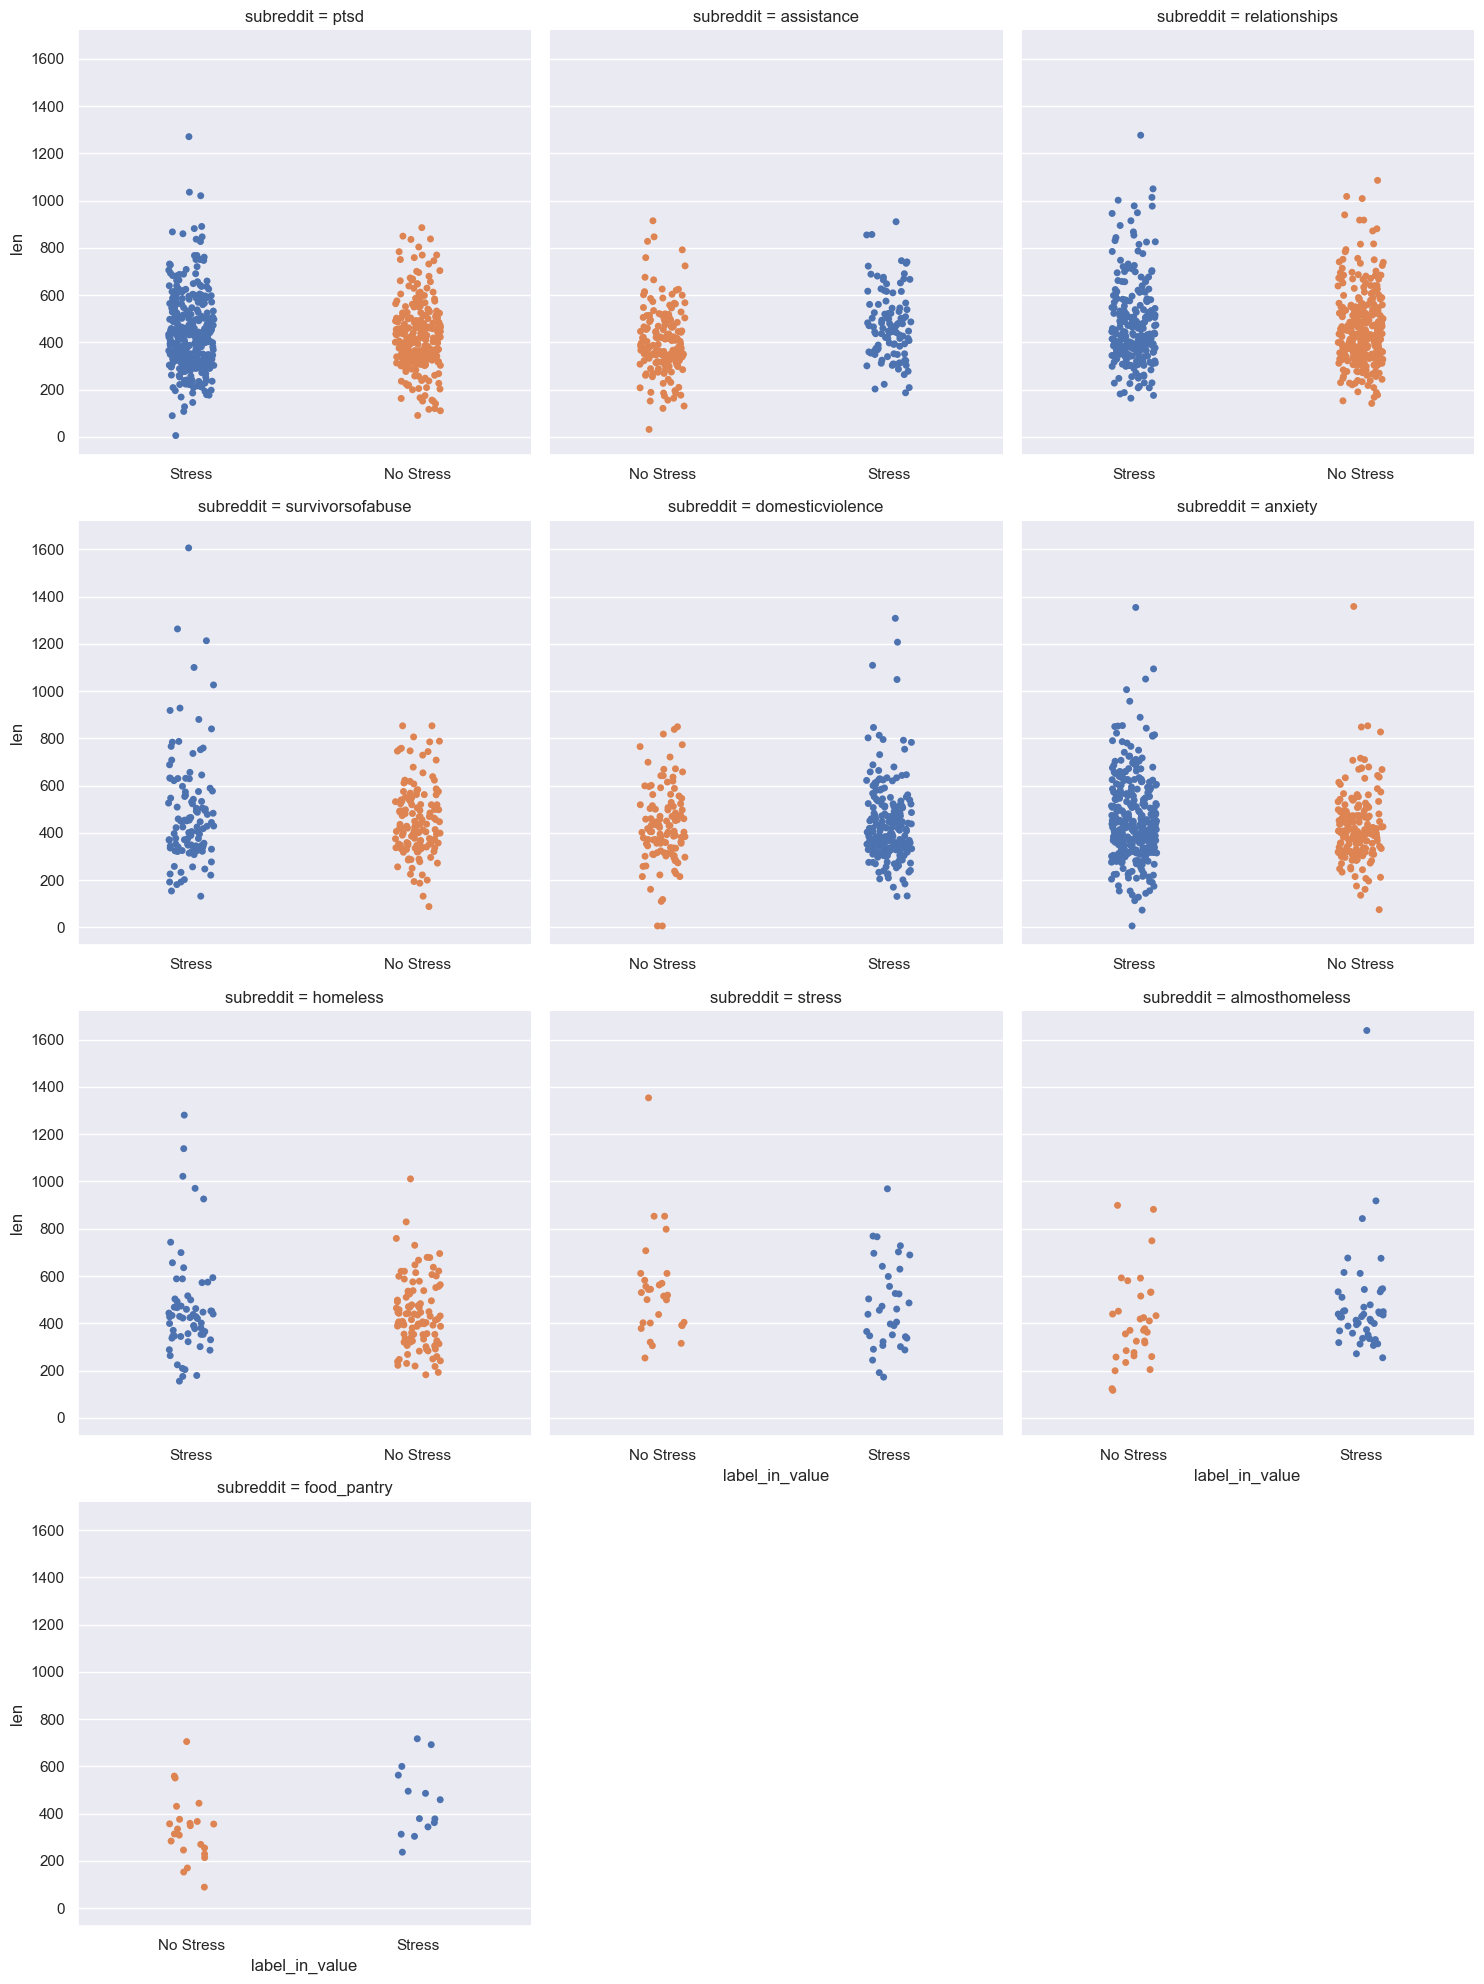

In [24]:
sns.catplot(data=human_stress,x='label_in_value',y='len',col='subreddit',col_wrap=3,hue='label_in_value',sharex=False)
plt.show()

# División de datos:

In [25]:
X=human_stress['text'].values
y=human_stress['label_in_value'].values

In [26]:
# division de los datos de entrenamiento(75%) y test(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Funcion para eliminar el signo de puntuación "."  y convertir la cadena en una lista de las palabras, todas en minusculas

In [27]:
def text_clean(text_message):
    
    remove_punc=[ text for text in text_message if text not in string.punctuation]
    
    remove_punc= ''.join(remove_punc)
    
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

### Pruebas de los resultados de la funcion *text_clean()* :

In [28]:
human_stress['text'].head(5)

0    He said he had not felt that way before, sugge...
1    Hey there r/assistance, Not sure if this is th...
2    My mom then hit me with the newspaper and it s...
3    until i met my new boyfriend, he is amazing, h...
4    October is Domestic Violence Awareness Month a...
Name: text, dtype: object

In [29]:
human_stress['text'].head(5).apply(text_clean)

0    [said, felt, way, suggeted, go, rest, TRIGGER,...
1    [Hey, rassistance, sure, right, place, post, g...
2    [mom, hit, newspaper, shocked, would, knows, d...
3    [met, new, boyfriend, amazing, kind, sweet, go...
4    [October, Domestic, Violence, Awareness, Month...
Name: text, dtype: object

# Algoritmo Multinomial Naive Bayes y Busqueda mediante Grid  

In [30]:
parameters = {
    'bow__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'classifier__alpha': (1e-2, 1e-3),
}


# Pipeline

In [31]:
pipeline_clf=Pipeline([('bow',CountVectorizer(analyzer=text_clean)),
                   ('tfidf',TfidfTransformer()),
                   ('classifier',MultinomialNB())
                  ])

In [32]:
gs_clf = GridSearchCV(pipeline_clf, parameters, cv=7)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function text_clean at 0x0000016BCD4CCAF0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'bow__ngram_range': [(1, 1), (1, 2)],
                         'classifier__alpha': (0.01, 0.001),
                         'tfidf__use_idf': (True, False)})

In [33]:
predictions=gs_clf.predict(X_test)

In [34]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

   No Stress       0.76      0.57      0.65       335
      Stress       0.69      0.84      0.76       375

    accuracy                           0.71       710
   macro avg       0.72      0.70      0.70       710
weighted avg       0.72      0.71      0.71       710



In [35]:
from scipy.stats import mannwhitneyu

# Realizar la prueba de Mann-Whitney
stress_text_len = human_stress[human_stress['label_in_value'] == 'Stress']['len']
no_stress_text_len = human_stress[human_stress['label_in_value'] == 'No Stress']['len']

statistic, p_value = mannwhitneyu(stress_text_len, no_stress_text_len)

# Imprimir los resultados
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 1065661.5
p-value: 0.004952257110921933
